233840 - Elton Cardoso do Nascimento


201270 - Leonardo Rener de Oliveira


# Guia para a aula experimental

Nesse guia trataremos passo a passo a conexão de um dispositivo com a plataforma Konker.
Para seguir esse roteiro, você precisará de uma conta na Konker, que pode ser criada em https://demo.konkerlabs.net/ e, caso deseje trabalhar com o kit disponibilizado para vocês, será necessário baixar a Arduino IDE e adicionar o suporte a placa de desenvolvimento **NodeMCU**, além de instalar as bibliotecas **PubSubClient** e **ArduinoJSON**, caso você esteja fazendo essa atividade em um PC pessoal. Nesse caso, um guia de instalação da placa pode ser visto na referência https://www.filipeflop.com/blog/programar-nodemcu-com-ide-arduino/ enquanto a instalação das bibliotecas pode ser feita sem dificuldades buscando pelo nome das mesmas na caixa aberta ao selecionar o menu **Sketch** -> **Incluir Biblioteca** -> **Gerenciar Bibliotecas**.

**Se essa tarefa estiver sendo realizada dentro do laboratório da diciplina, não é necessário a instalação da IDE nem mesmo das bibliotecas.**

##**Importante:** para salvar esse guia você deve fazer login em uma conta do Google e clicar em *Arquivo* -> *Salvar uma cópia no Drive*. A entrega da atividade deve ser feita em PDF, logo, ao terminar de fazer a atividade e preencher suas respostas você pode imprimir esse guia diretamente para um arquivo PDF clicando em *Arquivo* -> *Imprimir* -> *Destino: Salvar como PDF*.
##**Antes de imprimir em PDF, lembre-se de apagar suas credenciais da plataforma do texto**.

Vamos iniciar nosso notebook chamando todas as bibliotecas que usaremos. Nessa etapa, nada precisa ser modificado.

!pip install arrow bokeh paho.mqtt


In [1]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import pprint
import numpy as np
import arrow
import requests
import json
from threading import Timer

O próximo passo é definir os endereços que serão usados para consultar e enviar os dados. Nessa etapa ainda não é necessário fazer modificações.

In [2]:
#Url de publicacao dos dados
pub_url = 'https://data.demo.konkerlabs.net/pub/'
#Url da API
base_api = 'https://api.demo.konkerlabs.net'
#Application padrão
application = 'default'

Agora vamos colocar em duas variáveis o seu usuário e senha da plataforma

(seu email e senha que você criou quando abriu conta na plataforma):

In [3]:
username = ""
password = ""

O próximo passo é criar o dispositivo dentro de sua conta na Konker. Você pode criar o dispositivo com o nome de sua preferência, lembre-se apenas de modificar nas função abaixo para o nome adequado. Caso queira usar o nome *termometro*, não é necessário alterar nada na próxima célula.

In [8]:
termometro_name = "Termometro"

## Usando o Kit de Hardware
Esse é o momento de você baixar o código dos dispositivos disponível em nosso GitHub: https://github.com/KonkerLabs/arduino_examples. Você deve baixar o código **Termometro_MQTT**. Depois de baixar o código, abra o código do Termometro na Arduino IDE e mude os parâmetros de rede Wifi, canal de publicação (minha sugestão é usar *temperatura*) credenciais do dispositivo.

![term](https://raw.githubusercontent.com/KonkerLabs/arduino_examples/master/Termometro_MQTT/term.jpg "Termômetro")

Com o dispositivo montado, o próximo passo é compilar e gravar o Firmware. Lembre-se de mudar a board na Arduino IDE para **NodeMCU v1.0**.

Caso tudo tenha dado certo até o momento, você começará a observar os dados sendo enviados para a plataforma. Entre na Guia de Devices e procure *Messages* do seu dispositivo termômetro. Você deve ver os dados de temperatura chegando.

**Aguarde ao menos 1 minuto registrando a temperatura ambiente. Após isso, segure o termistor com seus dedos fazendo a temperatura subir. Mantenha o termômetro aquecido com seus dedos por ao menos 30 segundos. Por último, deixe o dispositivo capturando novamente dados de temperatura ambiente enquanto roda o restante do notebook.**

## **Pergunta 1: Seguindo os passos descritos na célula acima (aguardar 1 minuto em temperatura ambiente e 30 segundos com o dedo no termistor), descreva a curva vista na aba "Mensagens" do dispositivo termômetro na plataforma.**

A curva nos primeiros 60 segundos é estável, praticamente constante. No momento em que o termistor foi segurado, ela começou a crescer rapidamente, com a taxa de variação diminuindo e a curva se tornando constante por alguns instantes. Após soltar o termistor ela caiu, se estabilizando novamente no valor mais baixo inicial.

## Usando a API da Konker para obter os dados e analisa-los localmente
Para iniciar esse trabalho, vamos primeiro conectar na API da Konker. A API usa OAuth2, então primeiro vamos obter as credenciais.

In [5]:
client = BackendApplicationClient(client_id=username)
oauth = OAuth2Session(client=client)
token = oauth.fetch_token(token_url='{}/v1/oauth/token'.format(base_api),
                                       client_id=username,
                                       client_secret=password)

Ótimo! Agora nos podemos começar a usar a API. Caso você queira mais detalhes de sua utilização, pode encontrar documentação em: https://api.demo.konkerlabs.net .

Vamos começar listando os dispositivos registrados no seu usuário.

In [6]:
devices = oauth.get("https://api.demo.konkerlabs.net/v1/{}/devices/".format(application)).json()['result']
for dev in devices:
    print(dev)

{'id': 'termometro', 'name': 'Termometro', 'description': 'Termometro MC833', 'locationName': 'default', 'deviceModelName': 'default', 'active': True, 'debug': False, 'tags': [], 'guid': 'd24db1a5-c52f-4f13-98b0-21d06fd1d54c'}


Vamos procurar pelo dispositivo Termometro na sua lista de dispositivos:

In [9]:
guid_term=""
for dev in devices:
    if dev['name'] == termometro_name:
        guid_term = dev['guid']

print("O GUID do dispositivo Termômetro é: "+ guid_term)

O GUID do dispositivo Termômetro é: d24db1a5-c52f-4f13-98b0-21d06fd1d54c


Caso você consiga ver o GUID do dispositivo, significa que está tudo funcionando bem. Caso o GUID não apareça, revise o nome do dispositivo no Notebook e o nome escolhido na plataforma para garantir que eles possuem a mesma grafia.

Agora vamos usar a API para pegar os dados enviados pelo dispositivo termômetro hoje. Caso você tenha escolhido outro canal para envio dos dados, por favor modifique a variável **canal** na próxima célula.

In [10]:
canal = 'temperatura'
dt_start = arrow.utcnow().to('America/Sao_Paulo').floor('day')
dt_start = dt_start.shift(days=-1)
stats = oauth.get("https://api.demo.konkerlabs.net/v1/{}/incomingEvents?q=device:{} channel:{} timestamp:>{}&sort=oldest&limit=10000".format(application,guid_term,canal,dt_start.isoformat())).json()['result']
print(stats)

[{'timestamp': '2023-06-14T12:52:47.111Z', 'ingestedTimestamp': '2023-06-14T12:52:47.111Z', 'incoming': {'deviceGuid': 'd24db1a5-c52f-4f13-98b0-21d06fd1d54c', 'channel': 'temperatura'}, 'payload': {'deviceId': 'My_favorite_thermometer', 'metric': 'Celsius', 'value': 13.22619247}}, {'timestamp': '2023-06-14T12:52:48.992Z', 'ingestedTimestamp': '2023-06-14T12:52:48.992Z', 'incoming': {'deviceGuid': 'd24db1a5-c52f-4f13-98b0-21d06fd1d54c', 'channel': 'temperatura'}, 'payload': {'deviceId': 'My_favorite_thermometer', 'metric': 'Celsius', 'value': 13.08203983}}, {'timestamp': '2023-06-14T12:52:51.033Z', 'ingestedTimestamp': '2023-06-14T12:52:51.033Z', 'incoming': {'deviceGuid': 'd24db1a5-c52f-4f13-98b0-21d06fd1d54c', 'channel': 'temperatura'}, 'payload': {'deviceId': 'My_favorite_thermometer', 'metric': 'Celsius', 'value': 13.08203983}}, {'timestamp': '2023-06-14T12:52:53.112Z', 'ingestedTimestamp': '2023-06-14T12:52:53.112Z', 'incoming': {'deviceGuid': 'd24db1a5-c52f-4f13-98b0-21d06fd1d54c'

Caso tudo tenha funcionado como esperado, você deve estar vendo seus dados de temperatura logo acima. Para facilitar a visualização e análise dos dados, podemos transformar em um formato tabular com o Pandas.

In [11]:
from pandas.io.json import json_normalize
stats_df = json_normalize(stats).set_index('timestamp')
stats_df = stats_df[3:]
stats_df

<ipython-input-11-fa95c8e0b6cb>:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  stats_df = json_normalize(stats).set_index('timestamp')


,ingestedTimestamp,incoming.deviceGuid,incoming.channel,payload.deviceId,payload.metric,payload.value
timestamp,,,,,,
2023-06-14T12:52:53.112Z,2023-06-14T12:52:53.112Z,d24db1a5-c52f-4f13-98b0-21d06fd1d54c,temperatura,My_favorite_thermometer,Celsius,13.082040
2023-06-14T12:52:55.152Z,2023-06-14T12:52:55.152Z,d24db1a5-c52f-4f13-98b0-21d06fd1d54c,temperatura,My_favorite_thermometer,Celsius,13.082040
2023-06-14T12:52:57.355Z,2023-06-14T12:52:57.355Z,d24db1a5-c52f-4f13-98b0-21d06fd1d54c,temperatura,My_favorite_thermometer,Celsius,12.502655
2023-06-14T12:52:59.203Z,2023-06-14T12:52:59.203Z,d24db1a5-c52f-4f13-98b0-21d06fd1d54c,temperatura,My_favorite_thermometer,Celsius,12.357101
2023-06-14T12:53:01.278Z,2023-06-14T12:53:01.278Z,d24db1a5-c52f-4f13-98b0-21d06fd1d54c,temperatura,My_favorite_thermometer,Celsius,12.357101
...,...,...,...,...,...,...
2023-06-14T12:59:01.032Z,2023-06-14T12:59:01.032Z,d24db1a5-c52f-4f13-98b0-21d06fd1d54c,temperatura,My_favorite_thermometer,Celsius,13.082040
2023-06-14T12:59:03.152Z,2023-06-14T12:59:03.152Z,d24db1a5-c52f-4f13-98b0-21d06fd1d54c,temperatura,My_favorite_thermometer,Celsius,13.082040
2023-06-14T12:59:05.673Z,2023-06-14T12:59:05.673Z,d24db1a5-c52f-4f13-98b0-21d06fd1d54c,temperatura,My_favorite_thermometer,Celsius,13.082040


Ótimo! Agora os dados estão em um formato mais fácil de ler. Mas podemos também fazer um gráfico bem simples!

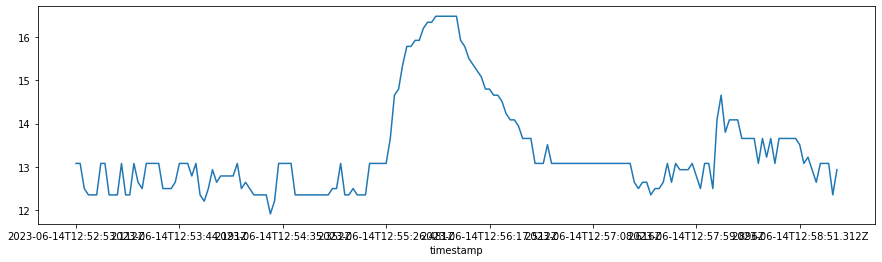

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))

stats_df['payload.value'].plot();

Agora começa a parte final desse trabalho. Vamos rodar um algoritmo conhecido com KMeans de aprendizado não supervisionado tentando encontrar os dois clusters que melhor separam nosso dataset. Como você pode observar abaixo, estamos usando a biblioteca SKLearn do Python para isso.

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(stats_df['payload.value'].values.reshape(-1, 1))

C:\Users\Elton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

Nós colocamos como condição a separação em 2 clusters. Vamos ver qual a previsão feita sobre os dados adquiridos:

In [15]:
predictions = kmeans.predict(stats_df['payload.value'].values.reshape(-1, 1))
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

Vamos observar a temperatura média do primeiro cluster de dados (grupo 0):

In [16]:
print('Temperatura média do grupo 0: ' + str(stats_df.loc[predictions == 0]['payload.value'].mean()) + ' C')

Temperatura média do grupo 0: 15.599770785714286 C


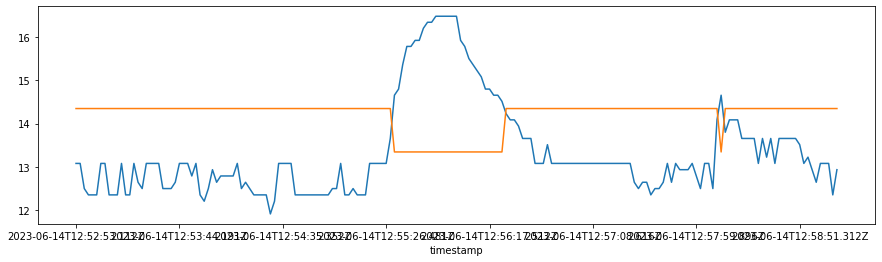

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))

stats_df['payload.value'].plot();
plt.plot(predictions+stats_df['payload.value'].mean())

##**Pergunta 2: O que representa o grupo 0 de temperaturas?**

O grupo 0 representa as temperaturas enquanto o termistor estava sendo segurado

E agora a temperatura média do segundo cluster (grupo 1):

In [19]:
print('Temperatura média do grupo 1: ' + str(stats_df.loc[predictions == 1]['payload.value'].mean()) + ' C')

Temperatura média do grupo 1: 12.944341767388535 C


##**Pergunta 3: O que representa o grupo 1 de temperaturas?**

O grupo 1 representa as temperaturas enquanto o termistor não estava sendo segurado.

Vamos ver agora como se comportam os dois clusters encontrados em um gráfico.

Nota: Nessa segunda versão do Notebook estou usando a biblioteca Bokeh para tentar evitar o gargalo em processamento gerado pelo Matplotlib na sala de aula. Caso você ainda encontre problemas em gerar o gráfico, por favor me envie um email em luis@konkerlabs.com

In [20]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
import pandas as pd
output_notebook()

Loading BokehJS ...

In [23]:
p = figure(width=820, height=400, x_axis_type="datetime",
           title="Clusters de temperatura encontrados pelo método KMeans",
           x_axis_label='Tempo',
           y_axis_label='Temperatura [Celsius]')

p.title.text_font_size = '18pt'
p.xaxis.axis_label_text_font_size = "14pt"
p.yaxis.axis_label_text_font_size = "14pt"

x = np.array(pd.to_datetime(stats_df.index))
y = np.array(stats_df['payload.value'])
n_y = np.multiply(np.array(stats_df['payload.value']),predictions)
n_y = np.clip(n_y,np.min(y),np.max(y))

# add a line renderer
p.line(x, y, line_width=2)
p.patch(x,n_y,color="red",alpha = 0.5,line_width=0)

show(p) # show the results

##**Pergunta 4: Como você interpreta esse gráfico? Ele representa bem o experimento?**

Ele demonstra como os dados estão separados em 2 clusters, um deles representando as temperaturas enquanto o termistor estava sendo segurado e outro quando ele não estava sendo segurado

Observe que em momento algum você precisou escolher um threshold para a divisão entre os clusters de temperatura. Muito embora esses dados representem coisas muito bem conhecidas, elas poderiam representar situações de trabalho diferentes em uma máquina, por exemplo.

##**Pergunta 5: Quais as vantagens e desvantagens do uso de protocolos de comunicação de alto nível? (Dica: consegue estimar o tráfego de dados gerado pelos 43 dispositivos durante 1 hora de aula?)**

Ele permite abstrair a comunicação entre os dispositivos, mascarando complexidades da implementação. Porém, ele diminui o controle sobre quais mensagens estão sendo transmitidas em níveis mais baixos (é difícil estimar o tráfego de dados, principalmente se considerarmos mensagens de controle do protocolo Wi-fi).

##**Pergunta 6: Cite uma situação real na qual esse método testado poderia ser aplicado.**

Controlar a temperatura de fornos em uma linha de produção de aço; ou controlar os condicionadores de ar do IC 3, tentando manter todas as salas na mesma temperatura.

##**Pergunta 7: O que é uma plataforma de IoT e o que você aprendeu com esse experimento?**

Uma plataforma de IoT é um plataforma capaz de agregar, tratar dados, armazenar e disponibilizar dados de diferentes dispositivos, abstraindo a comunicação entre eles e fornecendo diferentes serviços. 

Aprendemos neste experimento um pouco mais sobre dispositivos IoT, e como utilizar a plataforma da Konker, enviando e receber dados via APIs.